In [3]:
# Import all the necessary libraries for loading images
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import cv2
import glob
from keras.models import Sequential
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Image Size
IMAGE_HT = 256
IMAGE_WT = 256

# Image RGB
IMAGE_RGB = 3

In [5]:
# Original Image list

original_image = os.listdir('dataset/training/image_2')

In [6]:
# Masked Image list

masked_image = os.listdir('dataset/training/gt_image_2')

In [7]:
# Sort both sets of images to match with their pair

original_image.sort()
masked_image.sort()

In [8]:
# Check for the matching pairs

print(original_image[1])
print(masked_image[1])
print(original_image[2])
print(masked_image[2])

um_000001.png
um_000001.png
um_000002.png
um_000002.png


In [9]:
# Get X and y

y = np.zeros((len(masked_image), IMAGE_HT, IMAGE_WT, IMAGE_RGB), dtype = np.float32) # Target data

X = np.zeros((len(original_image), IMAGE_HT, IMAGE_WT, IMAGE_RGB), dtype = np.float32) 

for file in original_image:
    n = original_image.index(file)
    path1 = os.path.join('dataset/training/image_2', file)
    img = cv2.imread(path1, 1) # Original Image is in RGB format
    try:
        img = cv2.resize(img, (IMAGE_HT, IMAGE_WT))
        X[n] = img / 255
        
        file2 = masked_image[n]
        path2 = os.path.join('dataset/training/gt_image_2', file2)
        mask = np.array(cv2.imread(path2, 1)) #  Masked Image is in RGB format
        mask = cv2.resize(mask, (IMAGE_HT, IMAGE_WT))
        y[n] = mask / 255
    except Exception as e:
        print(e)
        print(path1)
        
        

In [10]:
print(X.shape)
print(y.shape)

(289, 256, 256, 3)
(289, 256, 256, 3)


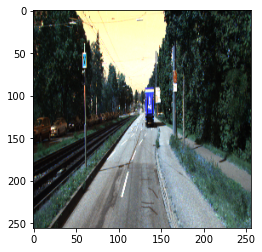

In [10]:
# check Images

imageId = 112

plt.imshow(X[imageId])

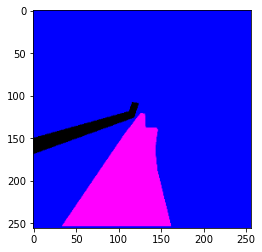

In [11]:
plt.imshow(y[imageId])

In [11]:
#split train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 101)

In [12]:
X_train.shape, X_test.shape

((245, 256, 256, 3), (44, 256, 256, 3))

In [13]:
# Calculating Dice Coefficients

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    
    return numerator / (denominator + tf.keras.backend.epsilon()) # tf.keras.backend.epsilon = 1e-07


In [14]:
# Calculating loss function

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [15]:
# UNet model

inputs = Input((IMAGE_HT, IMAGE_WT, IMAGE_RGB))

# Block 1
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
batch1 = BatchNormalization()(conv1)
#conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch1)
batch1 = BatchNormalization()(conv1)
#pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)

# Block 2
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Block 3
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Block 4
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

# Block 5
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(3, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

#model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.compile(optimizer = Adam(lr = 1e-4), loss = loss, metrics = [dice_coefficient])

model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization_1[0][0]   

In [ ]:
#  Train the model

history = model.fit(x=X_train, y=y_train, epochs=8, batch_size=30, verbose=1)
#model.fit(x=X_train, y=y_train, epochs=4, steps_per_epoch=10, batch_size=None, verbose=1)


Epoch 1/8


In [17]:
# Evaluate the model

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)  #  compare how the model performs on the test dataset

#print('\nTest accuracy:', test_acc)
print("nTest Accuracy:  {:.4f}".format(test_acc))


Test accuracy: 0.8439252376556396


 epochs=1, batch_size=30------ loss: 0.3275 - accuracy: 0.8898, Test accuracy: 0.937365710735321
 - epochs=1, batch_size=30------ loss: 1.4330 - dice_coefficient: 0.4369
 - epochs=2, batch_size=30------ loss: 1.3041 - dice_coefficient: 0.4628, Test accuracy: 0.46653616428375244
 - epochs=8, batch_size=30------ loss: 0.3939 - dice_coefficient: 0.8411, Test accuracy: 0.8439252376556396
 
 epochs=2, batch_size=30------ loss: 0.1466 - accuracy: 0.9448, Test accuracy: 0.9467130303382874
 
 epochs=4, batch_size=30------ loss: 0.1001 - accuracy: 0.9674, Test accuracy: 0.9727610945701599

In [22]:
# Plot Accuracy and Loss

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy') # Plot Training and validation accuracy
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss') # Plot Training and validation loss
    plt.legend()
    
plot_history(history)

NameError: name 'history' is not defined

In [18]:
# Predict on train and test set

pred_train = model.predict(X_train, verbose = 1)
#pred_test = model.predict(X_test, verbose = 1)

245/245 [==============================] - 114s 467ms/step


In [19]:
pred_train[1].shape

(256, 256, 3)

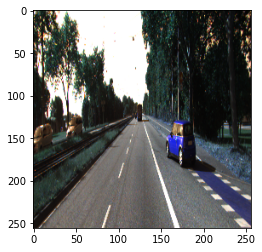

In [20]:
plt.imshow(X_train[1])

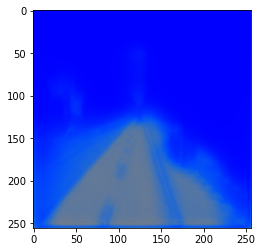

In [21]:
plt.imshow(pred_train[1])